# ENSDF Nuclear Level Density Interpolation

In the effort to use ML to predict cross section data, a very important feature that comes to mind are the nuclear levels. These are directly correlated to resonance location. How can we represent available data correctly and incorporate it into our EXFOR datasets? In this example, we go through a very simple approach where we load the cut-off ENSDF dataset and fit linear models to available nuclear level densities. It is not only the predictions that we save but also the models since we need to query them at the EXFOR datapoint energies.

In [1]:
# # Prototype
import sys
sys.path.append("..")

In [4]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import logging
import os

import nucml.datasets as nuc_data
import nucml.ensdf.plot as ensdf_plot
import nucml.ensdf.data_utilities as ensdf_utils
import nucml.model.building_utils as model_building
import nucml.general_utilities as gen_utils

In [5]:
figure_dir = "../Figures/"

With the modules imported, let us load the RIPL-cut ENSDF data.

In [6]:
ensdf_cutoff_df = nuc_data.load_ensdf_ml(cutoff=True, log=True, append_ame=True, basic=-1, num=False)

INFO:root:Dropping Ground State...
INFO:root:AME: Reading and loading Atomic Mass Evaluation files from: 
 C:/Users/Pedro/Desktop/ML_Nuclear_Data/AME/CSV_Files\AME_all_merged_no_NaN.csv
INFO:root:Finished. Resulting dataset has shape (20825, 75)


Also, let us create a unique ID for each dataset:

In [7]:
ensdf_cutoff_df["ID"] = ensdf_cutoff_df.Z.astype(str) + "_" + ensdf_cutoff_df.A.astype(str)
unique_ids = ensdf_cutoff_df.ID.unique()

## Fitting a Simple Linear Model

Having loaded the data we can fit a simple linear model to isotopic data using the `generate_level_density_csv()` utility. 

In [9]:
import importlib

In [17]:
importlib.reload(ensdf_utils)

<module 'nucml.ensdf.data_utilities' from '..\\nucml\\ensdf\\data_utilities.py'>

INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (36, 76)
INFO:root:Generating level density for 233U


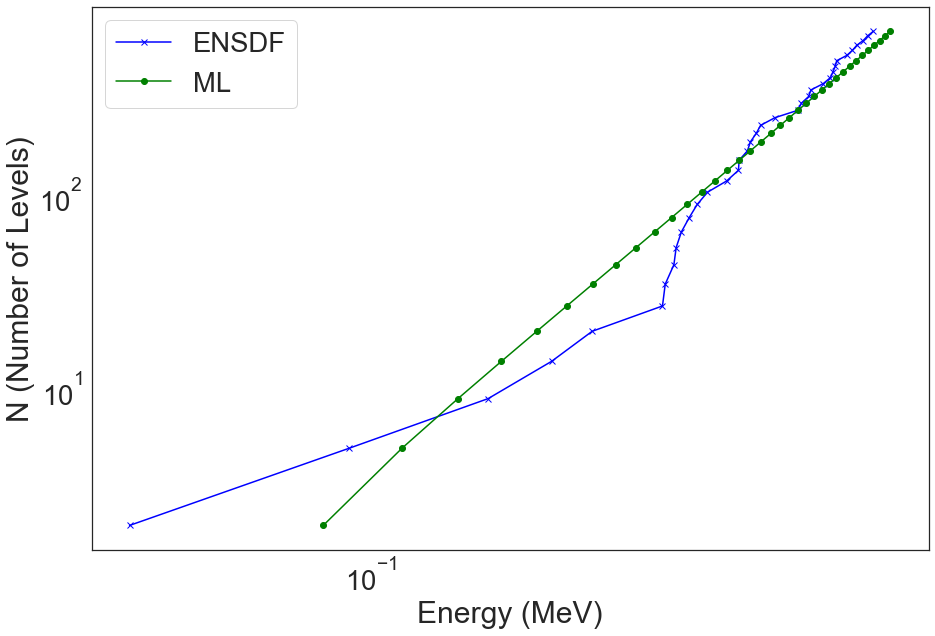

In [22]:
u233_nld = ensdf_utils.generate_level_density_csv(ensdf_cutoff_df, 92, 233, plot=True)

The function returns a DataFrame containing the Level Number, the Energy, and the Cumulative Number of Levels generated by the linear model.

In [23]:
pred_v1.head()

Level_Number    Energy     N
19488           2.0  0.083539   2.0
19489           3.0  0.112332   5.0
19490           4.0  0.138597   9.0
19491           5.0  0.163130  14.0
19492           6.0  0.186365  20.0

In our research efforts, we investigate ML models in data up to 20 MeV. This means we need nuclear level data up to that energy. The same function as above can be used but generate data up to those energies by giving the total number of levels to generate. 

INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (36, 76)
INFO:root:Generating level density for 233U
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (36, 76)
INFO:root:Expanded Dataset has shape: (500, 75)


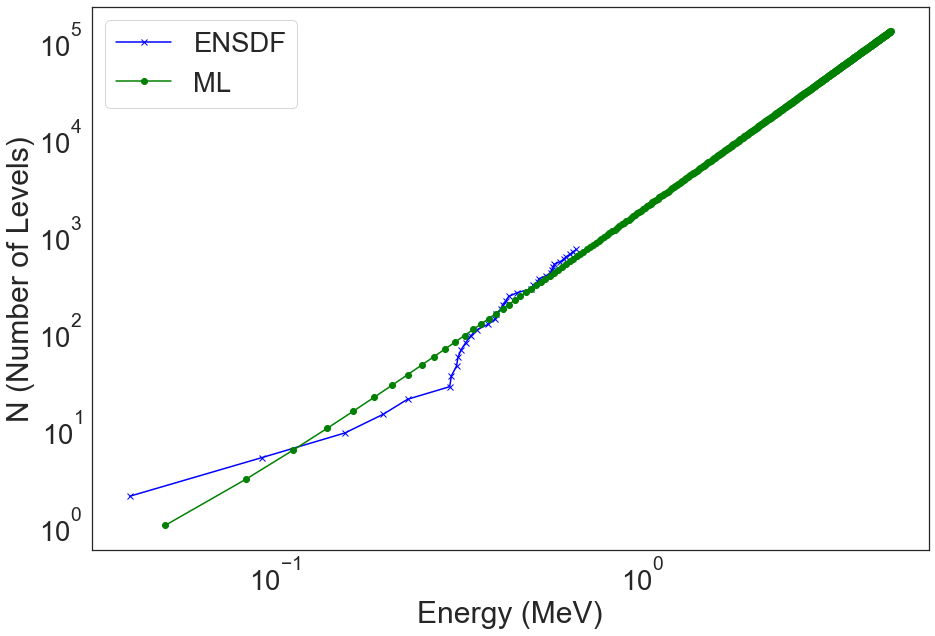

In [24]:
u233_nld_exp = ensdf_utils.generate_level_density_csv(ensdf_cutoff_df, 92, 233, tot_num_levels=500, plot=True)

In [25]:
u233_nld_exp.shape

(500, 3)

The model is trained to predict the energy given a level number. We cannot just use the model to predict NLD although you could fit a linear model also to the generated NLD. That makes more sense but here I will opt for brute force as an example. The following function will keep increasing levels until the predicted energy reaches 20 MeV.

In [26]:
# Since each iteration will generate a lot of output we will turn off the logger for now
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

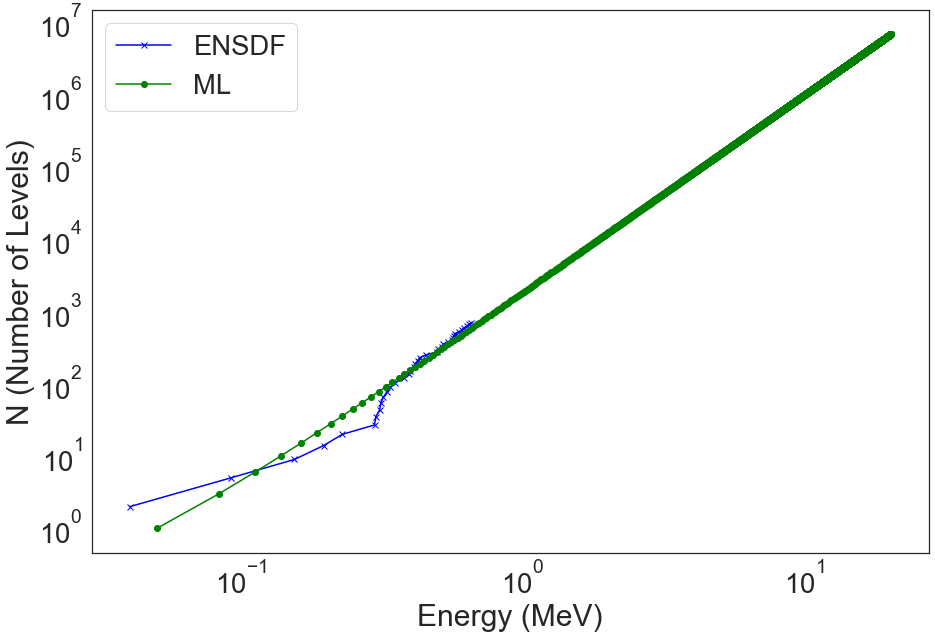

In [72]:
u233_20mev = ensdf_utils.generate_level_density_csv(ensdf_cutoff_df, 92, 233, plot=True,
                                                 get_upper=True, upper_energy_mev=20, it_limit=500)

In [73]:
u233_20mev.shape

(3700, 3)

## Saving Predictions and Model

We can now iterate through all elements in the `ensdf_cutoff_df` dataframe and use the same function to generate a CSV file and a `joblib` model that we can later used as needed. 

In [ ]:
# This list will allow us to obtain those isotopes for which we could not reach the target energy
not_reached = []

for i in unique_ids:
    Z, A = i.split("_")
    df_str = ensdf_utils.generate_level_density_csv(ensdf_cutoff_df, int(Z), int(A), save=True, tot_num_levels=500, 
                                                    get_upper=True, upper_energy_mev=20, it_limit=500,
                                                    saving_dir="Level_Density/")
    if type(df_str) == str:
        not_reached.append(df_str)

not_reached

You will notice that the `not_reached` list is empty. I found that 500 iterations allowed enough loops for every element to reach 20 MeV. We can take a look at the directory and see that we succesfully generated various isotopic files with level density data along with the saved linear model.

In [35]:
os.listdir("Level_Density/")[:10]

['100Mo_Level_Density.csv',
 '100Mo_linear_model.joblib',
 '100Ru_Level_Density.csv',
 '100Ru_linear_model.joblib',
 '101Ru_Level_Density.csv',
 '101Ru_linear_model.joblib',
 '102Pd_Level_Density.csv',
 '102Pd_linear_model.joblib',
 '102Ru_Level_Density.csv',
 '102Ru_linear_model.joblib']

## Getting Level Density at a Given Energy

Having the resultant files and DataFrame means we can query level density at various energies to get the cumulative number of levels.

In [74]:
u233_20mev.Energy = np.log10(u233_20mev.Energy)

In [76]:
np.log10(ensdf_utils.get_level_density(1, u233_20mev))

3.255272505103306

Perfect!